In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

matplotlib.rcParams.update({'font.size': 18})

#### Effect Heterogeneity 

The causal impact of a treatment is given by the average treatment effect (ATE):

$\tau = E[Y_1 - Y_0]$  -- for discrete treatment

$\tau = E[y^{'}(t)]$   -- for continous treatment where $y^{'}(t)$ is the derivative of the treatment response function (ie the coefficient of the treatment in a linear regression obtained from the derivative with respect to the treatment variable).

ATE estimation is the bedrock of causal inference and useful for program evaluation: when you want to know if you should roll out a treatment to the entire population or not. Sometimes its beneficial to know which unit you should treat. For example, should you prioritize a vaccine to one group over another, as those would benefit more from such treatment (eg during COVID, the older population was prioritized for vaccines). Personalization is key for such decisions. One way to acheive personalization is by taking effect heterogeneity into account by estimating the conditional average treatment effect (CATE).

$CATE = E[Y_1 - Y_0|X]\; or \; E[y^{'}(t)|X]$

Conditioning on X means that you allow treatment effect to be different depending on the characteristics, as defined by the covariates X of each unit. This is because, you believe not all entities respond equally well to the treatment and you want to leverage that heterogeneity. You want to treat only the right units (in the binary discrete case) or figure out the optimal treatment dosage for each unit (in the continuous case).


#### Prediction Is Not the Answer

The personalization task is a problem of customer segmentation. The aim is to create groups of customers based on how they respond to treatment, eg customers who respond well to discounts vs customers who respond poorly to them.
The customer's response to treatment ($ATE$) is $\frac{\delta Y}{\delta T}$. The slope can be used to partition the customer space into groups based on different responsiveness to treatment: customers who respond great to treatment (high treatment effect or high slope) and those who don't respond very well to it (low treatment effect or low slope). 

In traditional machine learning, you try to predict $Y$, rather than the derivative $\frac{\delta Y}{\delta T}$ for each unit. This would partition the space on the y-axis, and wouldn't necessarily lead to groups with different treatment effects.

Unlike raw outcome $Y$, slopes (rates of change) are nonobservable on a unit level. To see individual slopes, you have to observe each unit under different treatment levels and calculate how the outcome changes for each of those treatments:

$\frac{\delta Y_i}{\delta T_i} \approx \frac{Y(T_i-Y(T_i + \epsilon))}{T_i - (T_i+\epsilon)}$

This is the fundamental problem of causal inference again: you can't ever see the same unit under different treatment conditions. 

#### CATE with Regression

With most things in applied causal inference, the answer tends to start with linear regression. A key component of business is understanding when to give discounts to customers. The example below is that of a restaurant chain with 7 locations. The parent company ran a nationwide experiment that lasted three years, where it randomized discounts. The goal here is to understand when is the best time to give discounts. The data has one row per restaurant-day combination, meaning a unit is a restaurant-day combination. We simplify the problem by keeping prices consistent across restaurants so you'll treat days instead of customers. 

This business problem can be framed as a CATE estimation problem. If you create a model that outputs the sales sensitivity to discount for each day and covariate, then you can use that model to decide when to give a discount and how much discount to give.

$CATE = \frac{\delta }{\delta t}E[Sales|T=t,X]$

Since the treatment is randomized 

$CATE = \frac{\delta }{\delta t}E[Sales(t)|X]$

In [18]:
data = pd.read_csv("data/daily_restaurant_sales.csv")
data.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


In [19]:
data.shape

(7679, 11)

In [20]:
data.rest_id.nunique() # 7 restaurants

7

In [21]:
data.day.nunique()

1097

In [22]:
365*3  # experiment lasted 3 years

1095

In [23]:
7*1097 # one row per restaurant and day combination

7679

What we need, $\frac{\delta Y_i}{\delta T_i}$, is not observable, so you simply cannot use an ML algorithm and plug that as its target. But maybe you don't need to observe $\frac{\delta Y_i}{\delta T_i}$ in order to predict it. Say you fit a linear model to the data, with $t_i$ as a treatment feature and $X_i$ as a confounding covariate and differentiate it on the treatment:

$y_i = \beta _0 + \beta _1 t_i + \beta _2 X_i + e _i$

$\frac{\delta y_i}{\delta t_i}=\beta_1$

which is the $ATE$ for a randomized treatment. That is you can <i>predict slopes even though you can't observe them</i>. Still because its the ATE, you are predicting the constant value of $\hat \beta _1$ for every unit of restaurant-day combination instead of figuring out when to give discounts. Instead, you could change the model a bit by adding a treatment covariate interaction feature and differentiate it:

$y_i = \beta _0 + \beta _1 t_i + \beta _2 X_i +   \beta _3 t_iX_i  + e _i$

$\frac{\delta y_i}{\delta t_i}=\beta_1 + \beta _3 X_i$

Here $\beta _3$ is a vector coefficient for the features in $X$, and these slope predictions will change as X changes. Including the interaction between the treatment and covariates allow the model to learn how the effect changes by those same covariates. This is how regression gives a way of estimating $CATE$, even though you can't predict it directly. In other words, interaction terms in regression produce the CATE.

For our example, the covariates are date-specific features, like month, day of week, and if it's a holiday. We also have the average competitor's price, as this will probably affect how customers respond to discounts in each restaurant. We need to interact the covariates with the treatment. The * operator in statsmodels does exactly this (in sklearn you can use Polynomial features class to create interaction only features, via a keyword). The * operator includes an additive term for the left and right side plus an interaction term ie a\*b = a + b + a*b. For our example this would result in:

$sales_i = \beta _0 + \beta _1 discount_i + \beta _2 X_i*discount + \beta _3 X_i + e_i$

If you only want the interaction (multiplicative) terms, you can use the : operator. 

In [24]:
import statsmodels.formula.api as smf 

X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]
regr_cate = smf.ols(f"sales ~ discounts * ({'+'.join(X)})", # C(month) + C(weekday) + is_holiday + comp_price
                    data = data).fit() # interact treatment on confounders

After estimating the model, the predicted slope can be extracted from the parameter estimates:

$\frac{\delta sales_i}{\delta discounts_i}=\hat \beta _1 + \hat \beta _3 X_i$

$\beta _1$ is the discount coefficient and $\beta _3$ is the vector for the interaction coefficients. You could just extract those parameters from the fitted model. Another way to get the slope is to use the definition of the derivative.

$\frac{\delta y}{\delta t} = \frac{y(t+\epsilon) - y(t)}{(t+\epsilon)-t}$

with $\epsilon$ going to zero, you can approximate this definition by replacing $\epsilon$ with 1:

$\frac{\delta y}{\delta t} \approx \hat y(t+1) - \hat y(t)$

where $\hat y$ is given by model's predictions. Since this is a linear model, the approximation is exact. In otherwords, you'll make two predictions with your models: one passing the original data and another passing the original data but with the treatment incremented by one unit. The difference between those predictions is your $CATE$ prediction.

In [25]:
ols_cate_pred = (regr_cate.predict(data.assign(discounts = data["discounts"] + 1)) # add 1 to treatment
                 - regr_cate.predict(data)) # original treatment value

In [26]:
ols_cate_pred

0       53.302535
1       48.652492
2       47.547577
3       43.195858
4       42.108752
          ...    
7674    42.197410
7675    28.919270
7676    38.855831
7677    33.862166
7678    26.322954
Length: 7679, dtype: float64

#### Evaluating CATE Predictions 

To evaluate the CATE model and its predictions, we don't have the option of comparing actuals and predicted, since the actual treatment effect is not observed at a unit level. So far, our approach to CATE looks a lot like regular machine learning prediction, so maybe we can adapt some model evaluation techniques to evaluate the CATE model. To start with we split our data into a train and test set. In this example, because we have time dimension, we use that feature to split in a time-series-style manner. Then we refit the CATE model to only the training data for estimation and making predictions on the test set. Also, we can benchmark this regression model with a purely predictive machine learning model, which simply tries to predict the outcome Y, here we go with GradientBoostingRegressor. Also, we add a second benchmark which outputs random numbers between -1 and 1, to know if allocating treatment by a CATE model will be better than simply at random.

In [27]:
# Using the time dimension to split dataset
train = data.query("day<'2018-01-01'")
test = data.query("day>='2018-01-01'")

In [28]:
# fit to training data
X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]
regr_cate = smf.ols(f"sales ~ discounts * ({'+'.join(X)})", # C(month) + C(weekday) + is_holiday + comp_price
                    data = train).fit()

In [29]:
# predict on test data
cate_pred = (regr_cate.predict(test.assign(discounts = test["discounts"] + 1)) # add 1 to treatment
                 - regr_cate.predict(test)) # original treatment value

In [30]:
cate_pred

731     41.355802
732     44.743887
733     39.783798
734     40.770278
735     40.666949
          ...    
7674    42.446960
7675    28.696779
7676    38.631153
7677    34.023585
7678    26.683185
Length: 2562, dtype: float64

In [31]:
# benchmark machine learning model
from sklearn.ensemble import GradientBoostingRegressor 

X = ["month", "weekday", "is_holiday", "competitors_price", "discounts"]
y = "sales"

np.random.seed(1)
ml_model = GradientBoostingRegressor(n_estimators=50).fit(train[X], train[y]) # 50 trees in ensemble
ml_pred = ml_model.predict(test[X])

In [32]:
# add a random model 
np.random.seed(123)

test_pred = test.assign(ml_pred=ml_pred,        # add machine learning predicted outcome
                        cate_pred=cate_pred,    # add cate prediction for each sample
                        rand_m_pred=np.random.uniform(-1,1,len(test))) # random model predicting from uniform
test_pred

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,ml_pred,cate_pred,rand_m_pred
731,0,2018-01-01,1,0,False,True,False,False,4.92,5,251.5,236.312960,41.355802,0.392938
732,0,2018-01-02,1,1,False,False,False,False,3.06,10,541.0,470.218050,44.743887,-0.427721
733,0,2018-01-03,1,2,False,False,False,False,4.61,10,431.0,429.180652,39.783798,-0.546297
734,0,2018-01-04,1,3,False,False,False,False,4.84,20,760.0,769.159322,40.770278,0.102630
735,0,2018-01-05,1,4,False,False,False,False,6.29,0,78.0,83.426070,40.666949,0.438938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7674,6,2018-12-28,12,4,False,False,True,False,6.14,15,771.0,598.981916,42.446960,-0.672354
7675,6,2018-12-29,12,5,True,False,True,False,9.29,5,229.0,236.103487,28.696779,0.581846
7676,6,2018-12-30,12,6,True,False,True,False,5.29,10,458.0,411.551171,38.631153,-0.333955
7677,6,2018-12-31,12,0,False,False,True,False,6.78,10,403.0,390.745578,34.023585,0.506215


#### Effect by Model Quantile

CATE models come from the necessity of finding which units are more sensitive to treatment with the goal of allocating the treatment more efficiently. Thus CATE models come from a desire for personalization. Thus it would be useful to order units from more sensitive to less sensitive. With the predicted CATE, you can order units by that prediction and hope it also orders them by the real CATE. Since we can't evaluate that ordering on a unit level, we could evaluate groups defined by the ordering. If the treatment is randomly assigned, we don't have to worry about confounding bias. So to estimate the effect for a group of units, we compare the outcome between treated and untreated or to avoid the curse of dimensionality, we run a simple regression of Y on T inside that group.

$y_i = \beta _0 + \beta _1 t_i + e_i | X = x$

From the theory on simple linear regression:

$\hat \beta _1 = \frac{\Sigma (t_i - \bar t)y_i}{\Sigma (t_i - \bar t)^2}$

where $\bar t$ is the group sample average for the treatment and $\bar y$ is the group sample average for the outcome. Applying this entire function to the entire test set yields the ATE. The ATE is not what we want to know. Rather we want to know if the models can create partitions in the data that separate units into those that are more sensitive to the treatment from those that are less sensitive. You can segment the data by quantiles of your model's prediction and estimate the effect for each quantile. If the estimated effect in each quantile is ordered, you know the model is good at ordering the true CATE.

The effect is defined here, as estimated slope of regressing $Y$ on $T$. If you think the response is concave, you could define the effect as the slope of regressing $Y$ on $log(T)$ or $\sqrt T$. If you have a binary outcome, you can use the parameter estimate of a logistic regression, instead of from a linear regression. The aim is that if T is continous, you have to summarize the entire treatment response function into a single effect number.

Below we use the @curry decorator which allows us to specify partially defined functions. To calculate the treatment effect of each model prediction quantile, we pass only the outcome and treatment arguments. This will return a partially applied function that has the dataframe as the only missing argument. This is the type of function, .apply(...) expects.

In [33]:
# Curry decorator to create functions that can be partially applied
from toolz import curry 

@curry
def addN(x,N):
    return x + N 

ad5 = addN(N=5)
ad13 = addN(N=13)

print(ad5(5))
print(ad13(5))

10
18


In [34]:
@curry
def effect(data, y, t):   # treatment effect within a group (could be ate, cate, cumulative effect etc)
    return (np.sum((data[t] - data[t].mean())*data[y]) /
            np.sum((data[t] - data[t].mean())**2))      

In [35]:
# slope parameter estimate
effect(test, "sales", "discounts")  # effect for whole test set is the ate of the test set

32.16196368039615

In [36]:
# effect by quantile
def effect_by_quantile(df, pred, y, t, q=10):
    # makes quantile partitions of cate predictions, convert to IntervalIndex access the mid value and round
    groups = np.round(pd.IntervalIndex(pd.qcut(df[pred], q=q)).mid, 2) # deciles represented by mid values
    return (df
            .assign(**{f"{pred}_quantile": groups}) # add quantile group column (mid values of quantile group)
            .groupby(f"{pred}_quantile")            # group by quantile group column
            # estimate the effect on each quantile
            .apply(effect(y=y, t=t))    # effect is estimated slope of regressing Y on T in decile group
            ) # apply() supplies each grouped dataframe to effect() in turn so just supply other agguments

effect_by_quantile(test_pred, "cate_pred", y="sales", t="discounts")

cate_pred_quantile
17.50    20.494153
23.93    24.782101
26.85    27.494156
28.95    28.833993
30.81    29.604257
32.68    32.216500
34.65    35.889459
36.75    36.846889
39.40    39.125449
47.36    44.272549
dtype: float64

Notice how the estimated effect in the first quantile is lower than the estimated effect in the second quantile, which is lower than the estimated effect in the third quantile, and so on. This is evidence that the CATE prediction is indeed ordering the effect: days with lower predictive value also have low sensitivity to discount and vice versa. Also, the midpoint prediction in each quantile (index in the preceding column) is very close to the estimated effect for the same quantile. This means the CATE model also manages to predict the CATE quite correctly. In other words, you have a calibrated model for the CATE.

Plots comparing the CATE model, the machine learning model and the random model are below. The random model has roughly the same estimated effect in each of its partitions. Thus it won't help much with personalization, since it can't tell between days with high and low discount sensitivity. The effect in all of its partitions are just the ATE.

In the ML predictive model (which made sales predictions), groups with high sales predictions and low sales predictions are both more sensitive to discounts to varying degrees, unlike the random model that estimated the same effect in each of its partitions. However, it doesn't exactly produce an ordering score, though, but you could use it for personalization, by giving more discounts wherever there is indication of high treatment sensitivity (when sales predictions are either very high or very low).

Finally the CATE model can distinguish high to low effects, since groups with low CATE prediction has indeed lower sensitivity to discount than groups with high CATE predictions. This is evidenced by the staircase shape of its effect by quantile plot. In general, the steeper the staircase shape, the better the model in terms of ordering CATE.

The effect by quantile curve highlights which models are better at ordering sensitivity to treatment but if you have two decent models, the comparison migh not be that clear cut. Also, for model selection (like hyperparameter tuning or feature selection), it is ideal to summarize the quality of the model in a single number. This is achieved using the cumulative effect curve.


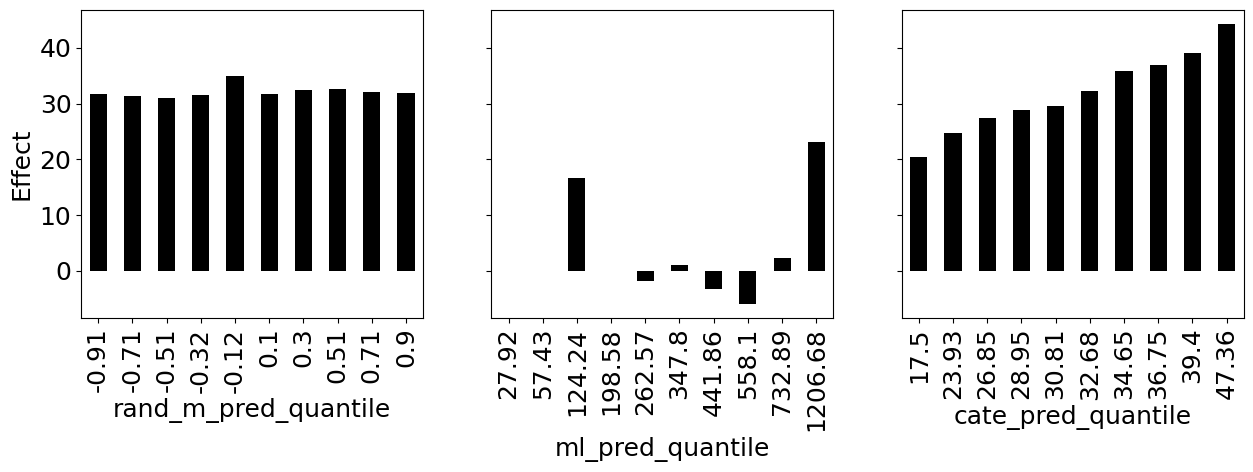

In [37]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,4))
for m, ax in zip(["rand_m_pred", "ml_pred", "cate_pred"], axs):
    effect_by_quantile(test_pred,m, "sales", "discounts").plot.bar(ax=ax) # different columns for diff models
    ax.set_ylabel("Effect")


#### Cumulative Effect

The idea is to use your model to define groups, estimate the effects inside those groups and accumulate one group on top of the other. First you need to sort the data by score. Then estimate the effect on the top 1%, according to that ordering. Next, add the following 1% and calculate the effect on the top 2% and so on and so forth. In otherwords, the data is sorted in descending order of some metric or score before calculating the cumulative effect.
The cumulative effect is plotted and the result is a curve of effect by cumulative sample.

If the score used to sort the data is good for ordering the true CATE, the resulting curve will start very high and gradually decrease to the ATE. This is because with each estimation, you are adding more samples, but the additional effect from the added samples is low, so the overall group effect is lowered, and when all samples are added the final effect is the ATE. A bad model will either quickly converge to the ATE or simply fluctuate around it all the time. 

The regression CATE model starts very high and gradually converges to the ATE. If you sort your data by this model, the ATE of the top 20% smoothly and gently lowers to the top 50% which smoothly and gently lowers to the ATE of the top 100% which is simply the global effect of the treatment (ATE). A model that simply outputs random numbers will just gravitate around the ATE and a model that reverse orders the effect will start below the ATE. Note that the ordering is not symmetric, ie taking a score and reversing it won't simply flip the curve around the ATE line.

An advantage of the cumulative effect curve over the effect by quantile curve is that the cumulative effect curve allows summarization into a single number: area under the curve. By computing the area between the curve and the ATE, one could compare different models. The bigger the area, the better the model. The downside to this is that the beginning of the curve will have the biggest area, and also the largest uncertainty, due to the smaller sample size. The fix to this is the cumulative gain curve.

Below when we use the query method on the ordered dataframe, we use index as the keyword. By default, the identifier index is used for the dataframe index, which allows you to treat the index as a column of the dataframe. This is a useful clarification because we reset the index and drop the column named index after ordering our dataframe but the identifier still allows us to filter based on the row index.

In [38]:
np.set_printoptions(linewidth=80, threshold=10) # how floating numbers are displayed

In [39]:
def cumulative_effect_curve(dataset, prediction, y, t,   # data, prediction, outcome, treatment columns
                            ascending=False, steps=100): # cumulative effect is done descendingly
    size = len(dataset)     # size of dataset, for cumulative calculation
    ordered_df = (dataset
                  .sort_values(prediction,  # sort rows by model prediction from highest to lowest 
                               ascending=ascending) 
                  .reset_index(drop=True))  # reset index so that new indices can be used for slicing below
    steps = np.linspace(size/steps, size, steps).round(0) # ending indices of cumulative groups; use round(0)
    return np.array([effect(ordered_df.query(f"index<={row}"), t=t, y=y) # slice data up to ending index
                     for row in steps]) # estimate the cumulative effect from beginning to row index

cumulative_effect_curve(test_pred, "cate_pred", "sales", "discounts")

array([49.65116279, 49.37712454, 46.20360341, ..., 32.46981935, 32.33428884,
       32.16196368])

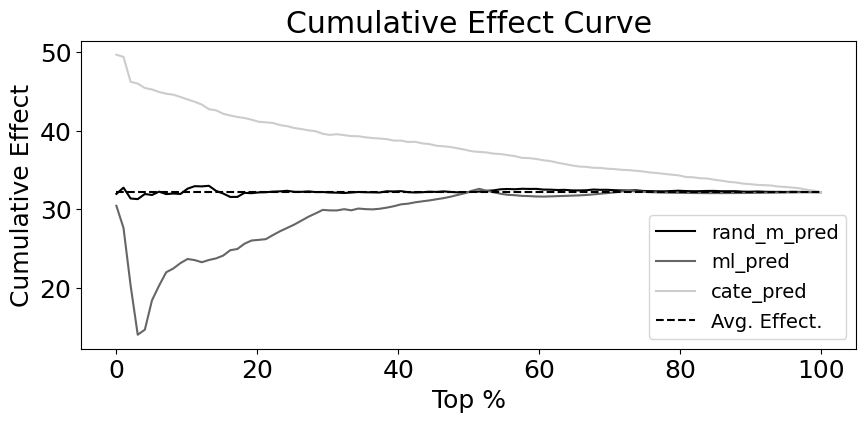

In [40]:
plt.figure(figsize=(10,4))

for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    cumu_effect = cumulative_effect_curve(test_pred, m, "sales", "discounts", steps=100) # 100 steps percentile
    x = np.array(range(len(cumu_effect)))  # range of indices for xlabel, one for each cumulative effect
    plt.plot(100*(x/x.max()), cumu_effect, label=m) # xlabel is top x% for each cumulative effect

plt.hlines(effect(test_pred, "sales", "discounts"), 0, 100, linestyles='--', 
           color="black", label="Avg. Effect.") # line indicating overall ATE for test set
plt.xlabel("Top %")
plt.ylabel("Cumulative Effect")
plt.title("Cumulative Effect Curve")
plt.legend(fontsize=14)

#### Cumulative Gain

The idea for cumulative gain follows from cumulative effect, but we multiply each point by the cumulative sample, $N_{cum}/N$ (proportion of total samples in group) to get the cumulative gain curve. The cumulative sample has a maximum of 1 for the top 100% when all rows are included. Now even though the beginning of the curve will have the highest effect, it will get downscaled by the small relative size. For example, in the example above, the top 1% of the regression CATE predictions have a treatment effect of around 50, but by scaling by the cumulative sample, we get a cumulative gain of 0.5. Note that the top 100% will have a cumulative gain equal to the ATE since the cumulative sample is 1 ie 32 * 1 = 32. 

Additionally, we can also choose to normalize this curve by the global treatment ATE by subtracting a normalizer from the effect at each iteration before multipying by the cumulative sample. So again for the top 1% we normalize the group treatment effect by subtracting the global treament of 32 so the normalized cumulative gain is (50-32)*0.1 = 0.18. Note that the normalized cumulative gain equals 0 ie (32-32)*1=0. 

In [41]:
def cumulative_gain_curve(df, prediction, y, t, ascending=False, 
                          normalize=False, steps=100): # by default we have percentiles, no normalization
    effect_fn = effect(t=t, y=y)           # treatment effect partial function (treatment, outcome specified)
    normalizer = effect_fn(df) if normalize else 0  # normalizer is, treatment effect for entire dataset or 0

    size = len(df)                          # total number of rows
    ordered_df = (df                        # rearrange rows in descending order of model prediction / score
                  .sort_values(prediction, ascending=ascending) # sort for cumulative effect calculation
                  .reset_index(drop=True))  # reset index for steps access below
    steps = np.linspace(size/steps, size, steps).round(0) # right end index of cumulative groups
    effects = [(effect_fn(ordered_df.query(f"index<={row}")) - normalizer)*(row/size) # row/size is group frac
               for row in steps] # cumulative effect, then subtract normalizer, scale by group size fraction
    return np.array([0]+ effects) # add a 0 to the front via concatenation then return 

cumulative_gain_curve(test_pred, "cate_pred", "sales", "discounts", normalize=False)

array([ 0.        ,  0.50387597,  0.982917  , ..., 31.82346463, 32.00615008,
       32.16196368])

When plotted, the better model in terms of ordering CATE is the one that has the biggest area between the curve and the line representing the ATE. To summarize the model performance into a singular number, you can just sum the values from the normalized cumulative gain curve. The model with the biggest value will be the best one in terms of ordering CATE. This number represents the area under the curve (AUC). Models that reverse-orders CATE will have negative areas. The fact that you can condense your model's performance into a single number allows for automated model selection.

It is important to know that each point in this curve is an estimate, not ground truth value. It is the estimate of the regression slope on a particular group. Since it is a regression estimate, it depends on the relationship between T and Y being correctly specified. Even with randomization, if the relationship between the treatment and the outcome is say a log function, estimating the effect as if it were a line will yield wrong results. If you find the shape of the treatment response function, you can adjust your effect function to be the slope of $y$ ~ $log(t)$ instead of $y$ ~ $t$. 

Second these curves don't care if you get the CATE right. All they care about is if the ordering is correct. For example, if you take any of the models and subtract -1000 from their predictions, their cumulative gain curve will remain unchanged. Even if you have a biased estimator for the CATE, the bias won't show up in these curves. If the goal is prioritizing treatment, then ordering is enough. If precisely estimating the CATE is the goal, the curves might be misleading. They are like ROC curves. A good ROC-AUC model won't necessarily be calibrated. 

Finally, all these methods require unconfounded data. If treatment is not randomized, the effects you'll estimate - in the subgroups or the ATE- will be wrong. You can debiase the data with orthogonalization or IPW, but its better to have experimental data so you can focus on effect heterogeneity without having to worry about confounding.

It is useful to use the effect by quantile plot alongside the cumulative gain curve, since the first gives some idea on how calibrated the model is while the second gives an idea how well it orders the CATE. The normalized cumulative gain, makes visualization easier.

Text(0.5, 1.0, 'Cumulative Gain Curve (Normalized)')

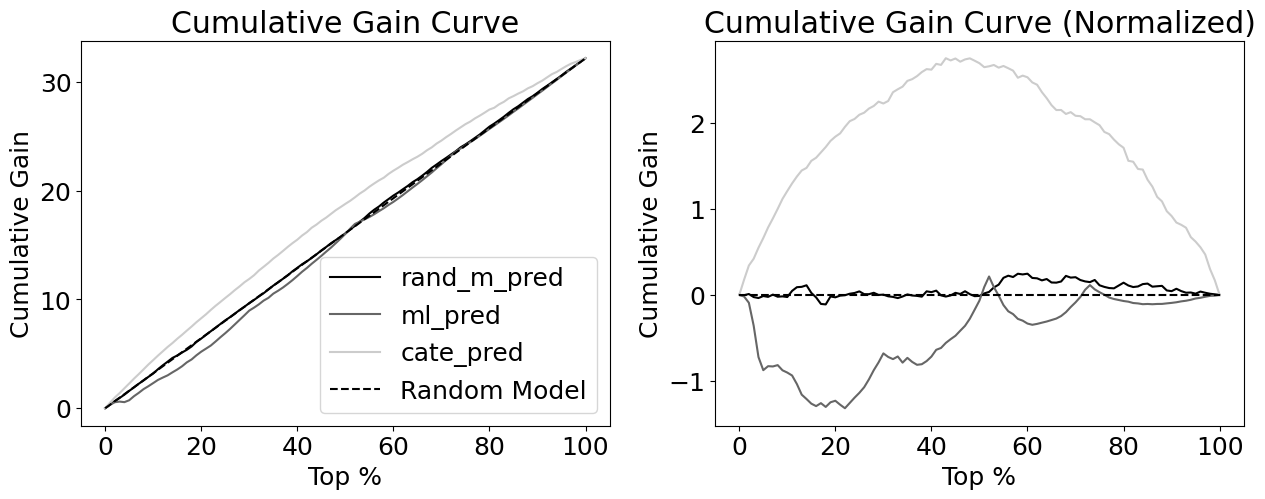

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    cumu_gain = cumulative_gain_curve(test_pred, m, "sales", "discounts")
    x = np.array(range(len(cumu_gain)))
    ax1.plot(100*(x/x.max()), cumu_gain, label=m)

ax1.plot([0,100], [0, effect(test_pred, "sales", "discounts")], linestyle="--", 
         label="Random Model", color="black") # line representing ATE
ax1.set_xlabel("Top %")
ax1.set_ylabel("Cumulative Gain")
ax1.set_title("Cumulative Gain Curve")
ax1.legend()



for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    cumu_gain = cumulative_gain_curve(test_pred, m, "sales", "discounts", normalize=True)
    x = np.array(range(len(cumu_gain)))
    ax2.plot(100*(x/x.max()), cumu_gain, label=m)

ax2.hlines(0,0, 100, linestyle='--', label="Random Model", color="black") # line representing the ATE
ax2.set_xlabel("Top %")
ax2.set_ylabel("Cumulative Gain")
ax2.set_title("Cumulative Gain Curve (Normalized)")

In [43]:
for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    gain = cumulative_gain_curve(test_pred, m, "sales", "discounts", normalize=True)
    print(f"AUC for {m}: ", sum(gain))   # the sum of the normalized gain curve gives the auc

AUC for rand_m_pred:  6.0745233598544495
AUC for ml_pred:  -45.44063124684
AUC for cate_pred:  181.7414717514399


#### Target Transformation 

Even though you can't observe the true treatment effect, $\tau (x_i)$, you can create a target variable that approximates it in expectation:

$Y_i^* = \frac{(Y_i - \hat \mu _y (X_i))(T_i - \hat \mu _t (X_i))}{(T_i - \hat \mu _t (X_i))^2}=\frac{Y_i - \hat \mu _y (X_i)}{T_i - \hat \mu _t (X_i)}$

where $\mu _y$ is a model for the outcome and $\mu _t$ is a model for the treatment. This target is simply result of dividing the residuals of an outcome and treatment model; its expectation is the individual treatment effect ie $E[Y_i^*]=\tau _i$. Notice how this formula looks a lot like the formula for the regression coefficient ('Effect by Model Quantile' above), with the numerator being the covariance between Y and T and the denominator, the variance of T. However, instead of using expectations to define those, it is computed on a unit level. Since this target approximates the true target effect, you can use it to compute deviance metrics, like the mean squared error (MSE). If your model for CATE is good in terms of prediciting the individual level effect $\tau _i$, then the MSe of its prediction with respect to this target should be small. This target will be incredibly noisy when close to the treatment average, where the denominator will tend toward zero. To fix that, you can apply weights that assign low importance to points where $(T_i - \hat \mu _t (X_i))$ is small. For instance, you can weight the units by $(T_i - \hat \mu _t (X_i))^2$. 

When we use build an outcome model and treatment model and divide their residuals to approximate the individual treatment effect, then we can calculate a weighted mean squared error with the CATE predictions of our regression CATE model, the random model and ML model. The regression CATE model is the best model and has the lowest weighted MSE. Also, the ML model performs worse than the random model; this is because the ML model is trying to predict $Y$ and not $\tau _i$. 

In [44]:
# the target is the residuals
X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]

y_res = smf.ols(f"sales ~ {'+'.join(X)}", data=test).fit().resid  # predicting outcome from covariates residuals
t_res = smf.ols(f"discounts ~ {'+'.join(X)}", data=test).fit().resid #predicting treatment from covariates resid

tau_hat = y_res / t_res 

In [45]:
from sklearn.metrics import mean_squared_error 

for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    wmse = mean_squared_error(tau_hat, test_pred[m], sample_weight=t_res**2) # weighted MSE
    print(f"MSE for {m}: ", wmse)

MSE for rand_m_pred:  1115.803515760459
MSE for ml_pred:  576256.7425385381
MSE for cate_pred:  42.90447405550264


#### When Prediction Models Are Good for Effect Ordering

Predicting $Y$ will only be good at ordering or predicting $\tau _i$ when the effect is correlated with the outcome, which will generally not be the case, but some situations like that are fairly common in business. For example, sales, $Y$, will be good at predicting days when customers are sensitive to discounts ($\tau (x_i)$), if the days when sales are high coincide with days when people are more sensitive to discounts. Generally, this can happen when the treatment response function is nonlinear.

One case where a model that predicts $Y$ can also be good at ordering CATE ($\tau _i$), is when the treatment response function is concave ie additional units of treatment have less and less effect. This is common in busines because things tend to have a saturation point. For examples, due to factors limiting production, the number of sales can only go so high, even if you set a discount to 100%. A model that predicts a concave $Y$ can be good at ordering the CATE because the higher the outcome $Y_i$, the lower the treatment effect $\tau _i$. Thus if you take the predictions of such a model and sort by the inverse of these predictions, you'll have a decent CATE ordering.

Another common situation where a model that predicts $Y$ can be good for ordering the CATE is when the outcome $Y$ is binary, will a customer default or not default. In this case, $E[Y|T]$ has an S shape, flattening out at 0 and 1. The data will be concentrated at one or the other end of this S-shaped function. In banking, only a small fraction of customers default on their loans. So if you have a model that predicts customer default, you will mostly be on the left side of the S curve. The customers on the right side, with higher predictions, will also be more sensitive to treatment. Intuitively, those are customers that are close to the tipping point between not defaulting and defaulting, and for them, a small change in treatment can make all the difference. In general, when the outcome is binary, the closer you are to the middle - that is $E[Y|X]=50%$ - the higher the effect will be. 


